# Divergences for GVI BNN

In [1]:
import os
import sys
import math
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Custom
from utils.data import plot_toy_dataset, toy_dataset, plot_toy_regions
from utils.metrics import expected_calibration_error
from BNN_GVI_LR import BNN_GVILR

### General hyperparameters

In [2]:
dev = torch.device('cuda:0')

epochs = 5000
hidden_size = [30]

pmean, plog_var = torch.Tensor([0]), torch.Tensor([0])

### Toy dataset

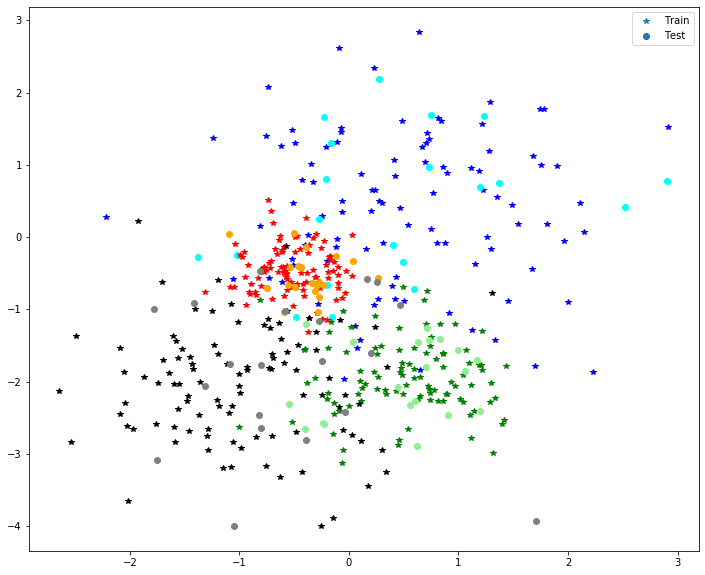

In [3]:
N = 400  # Samples to use

(X_tr, Y_tr), (X_te, Y_te) = toy_dataset(N=N)

N_tr = X_tr.shape[0]
N_te = X_te.shape[0]

plot_toy_dataset((X_tr, Y_tr), (X_te, Y_te))

In [4]:
X_tr = X_tr.to(dev)
Y_tr = Y_tr.to(dev)
X_te = X_te.to(dev)
Y_te = Y_te.to(dev)

### Train function

In [5]:
def train_bnn(bnn):
    
    optimizer = torch.optim.Adam(bnn.parameters(), lr=0.03)
    
    bnn_loss = []
    bnn_D = []
    bnn_NLL = []
    bnn_col = []
    bnn_train_error = []
    bnn_test_error = []
    
    # Train loop
    t0 = time.time()

    for e in range(epochs):

        cum_loss = 0
        cum_D = 0
        cum_NLL = 0
        cum_acc = 0
        cum_col = 0



        # Train
        bnn.train()
        _loss, _NLL, _D = bnn.ELBO(X_tr, Y_tr, warm_up=(e<10))

        preds = bnn(X_tr)
        _, _preds = torch.max(preds, dim=1)
        _acc = torch.sum(_preds==Y_tr)

        cum_loss += _loss.item()
        cum_NLL += _NLL.item()
        cum_D += _D.item()

        cum_acc += _acc.item()

        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        cum_col += bnn._get_collapsed_posterior()


        # Test
        if e%50 == 0:
            bnn.eval()
            test_acc = 0
            preds = bnn.predictive(X_te, n_samples=100)

            _, _preds = torch.max(preds, dim=1)
            _acc = torch.sum(_preds==Y_te)
            test_acc += _acc.item()

        bnn_loss.append(cum_loss)
        bnn_D.append(cum_D)
        bnn_NLL.append(cum_NLL)
        bnn_col.append(cum_col.item())
        bnn_train_error.append(100.*(cum_acc)/N_tr)
        bnn_test_error.append(100.*(test_acc)/N_te)

        if e%5 == 4:
            print('epoch: {}, at time: {:.2f}, loss: {:.3e}, NLL: {:.3e}, D: {:.3e}, Train Acc: {:.2f}, Test Acc: {:.2f}, Collapsed params: {:.3f}%'.format(
                  e, time.time()-t0, bnn_loss[-1], bnn_NLL[-1], bnn_D[-1], bnn_train_error[-1], bnn_test_error[-1], bnn_col[-1]), end='\r')
            
    bnn.eval()
    
    train_acc, train_ece = bnn.evaluate(X_tr, Y_tr)
    test_acc, test_ece = bnn.evaluate(X_te, Y_te)
            
    h = {
        'loss': bnn_loss,
        'D': bnn_D,
        'NLL': bnn_NLL,
        'col': bnn_col,
        'train_e': bnn_train_error,
        'test_e': bnn_test_error,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_ece': train_ece,
        'test_ece': test_ece,

    }
            
    return h

In [6]:
def plot_training(h):
    fig, ax_arr = plt.subplots(2, 2, figsize=(16, 14))

    ax_arr[0, 0].plot(h['NLL'])
    ax_arr[0, 0].set_yscale('log')
    ax_arr[0, 0].set_title('NLL')


    ax_arr[0, 1].plot(h['D'])
    ax_arr[0, 1].set_yscale('log')
    ax_arr[0, 1].set_title('D')
    
    ax_arr[1, 0].plot(h['col'])
    ax_arr[1, 0].set_title('collapsed params')

    ax_arr[1, 1].plot(h['train_e'])
    ax_arr[1, 1].plot(h['test_e'])
    ax_arr[1, 1].set_title('Accuracy')
    ax_arr[1, 1].legend(['Train', 'Test'])

    plt.show()

## Train BNNs with different divergences:

In [7]:
divergences = ['KL', 'rKL', 'F', 'J', 
               'A', 'A', 'A',
               'AR', 'AR', 'AR',
               'B', 'B', 'B',
               'G', 'G', 'G']
d_params = [None, None, None, None,
            0.5, 0.1, 0.01,
            0.75, 0.5, 0.25,
            1.05, 1.25, 1.5,
            1.05, 1.25, 1.5]

In [8]:
bnns = []
for D, D_par in zip(divergences, d_params):
    print("%%% Fitting BNN with divergence {} and d_param: {}".format(D, D_par))
    bnn = BNN_GVILR(2, 4, pmean, plog_var, divergence=D, d_param=D_par, hidden_size=hidden_size).to(dev)
    h = train_bnn(bnn)
    
    print("\n \t ### Train results:")
    print("\t \t Acc: {:.2f}".format(h['train_acc']*100))
    print("\t \t ECE: {:.2f}".format(h['train_ece']*100))
    
    print("\t ### Test results:")
    print("\t \t Acc: {:.2f}".format(h['test_acc']*100))
    print("\t \t ECE: {:.2f}".format(h['test_ece']*100))
    
    print("\t Collapsed params: {:.3f}".format(sum(h['col'][-15:])/15.))
    
    
    bnns.append({
        'model': bnn.cpu(),
        'divergence': D,
        'd_param': D_par,
        'history': h
    })

%%% Fitting BNN with divergence KL and d_param: None
epoch: 4999, at time: 920.43, loss: 2.912e+02, NLL: 1.917e+02, D: 9.949e+01, Train Acc: 81.25, Test Acc: 73.75, Collapsed params: 0.000%
 	 ### Train results:
	 	 Acc: 83.75
	 	 ECE: 4.85
	 ### Test results:
	 	 Acc: 73.75
	 	 ECE: 10.97
	 Collapsed params: 0.000
%%% Fitting BNN with divergence rKL and d_param: None
epoch: 4999, at time: 944.73, loss: 4.771e+02, NLL: 3.065e+02, D: 1.706e+02, Train Acc: 74.25, Test Acc: 73.75, Collapsed params: 0.000%
 	 ### Train results:
	 	 Acc: 82.50
	 	 ECE: 11.53
	 ### Test results:
	 	 Acc: 73.75
	 	 ECE: 12.83
	 Collapsed params: 0.000
%%% Fitting BNN with divergence F and d_param: None
epoch: 4999, at time: 801.81, loss: 4.232e+02, NLL: 3.514e+02, D: 7.178e+01, Train Acc: 68.00, Test Acc: 73.75, Collapsed params: 22.196%
 	 ### Train results:
	 	 Acc: 84.25
	 	 ECE: 15.13
	 ### Test results:
	 	 Acc: 73.75
	 	 ECE: 13.58
	 Collapsed params: 21.121
%%% Fitting BNN with divergence J and d_param

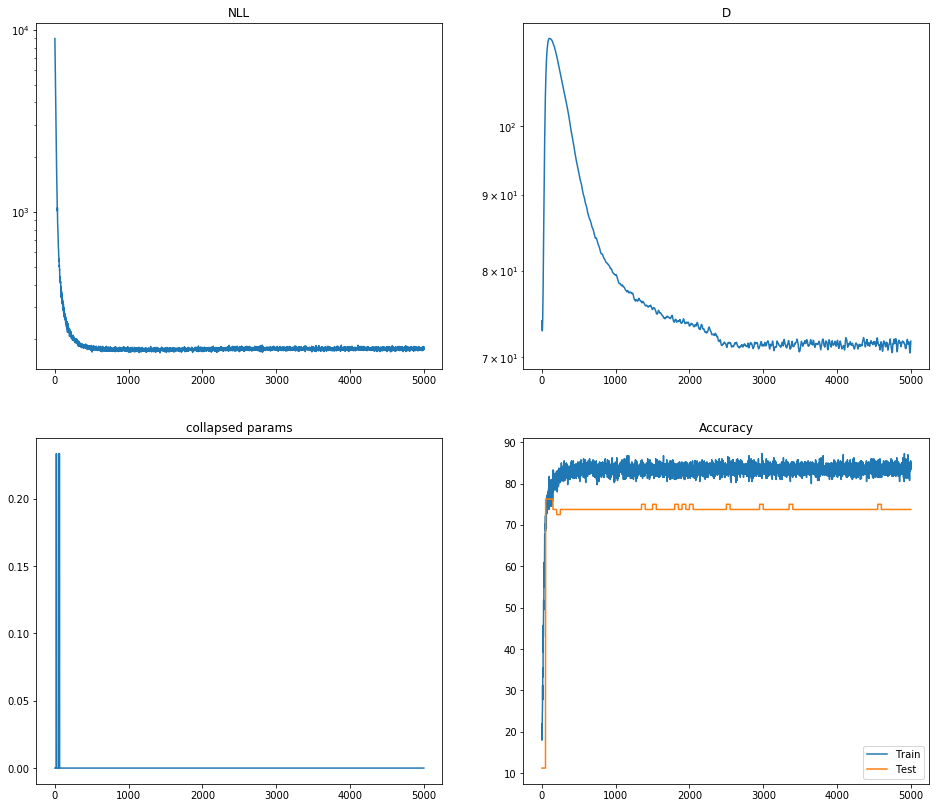

In [9]:
plot_training(bnns[11]['history'])

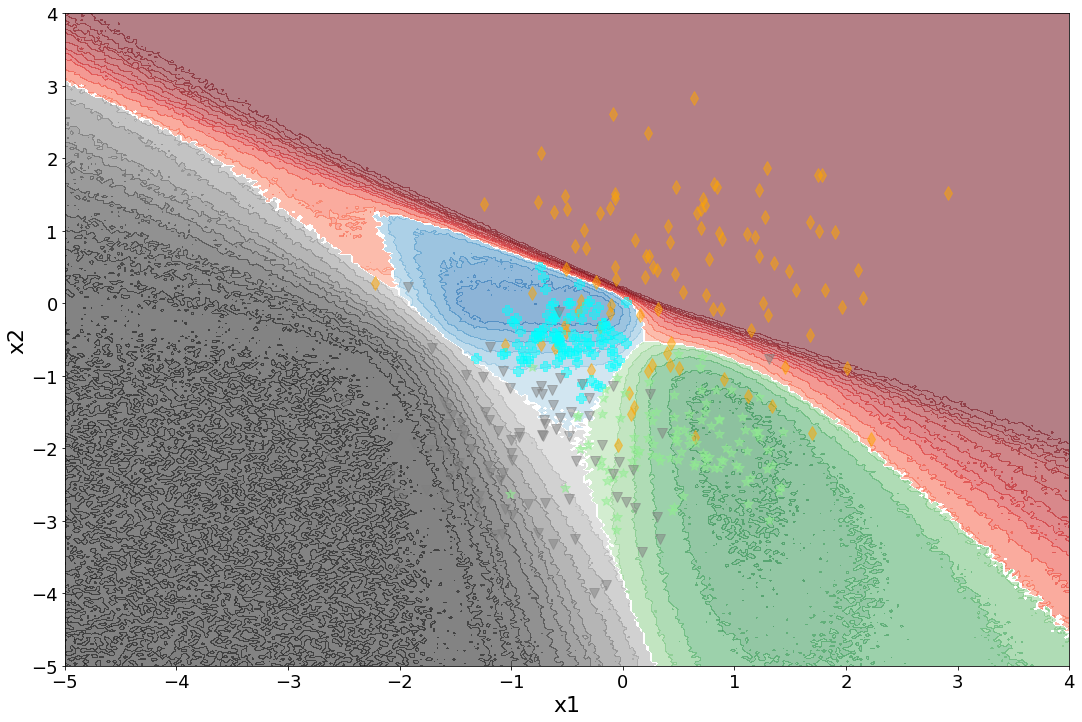

In [10]:
plot_toy_regions((X_tr, Y_tr), (X_te, Y_te), bnns[2]['model'])

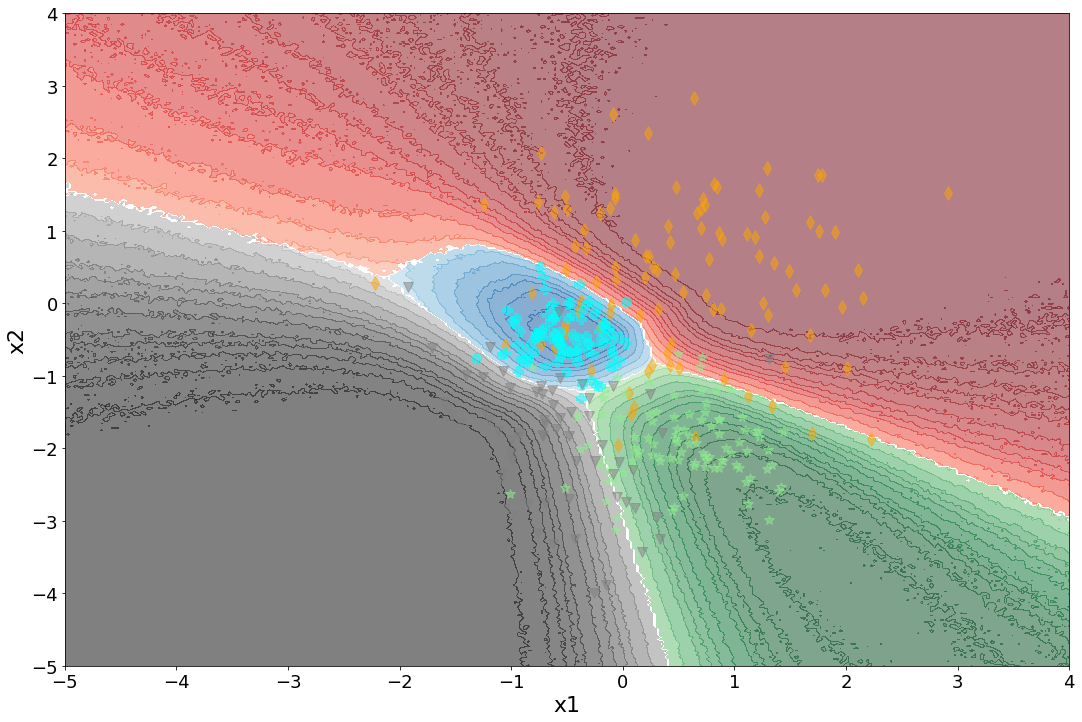

In [11]:
plot_toy_regions((X_tr, Y_tr), (X_te, Y_te), bnns[0]['model'])

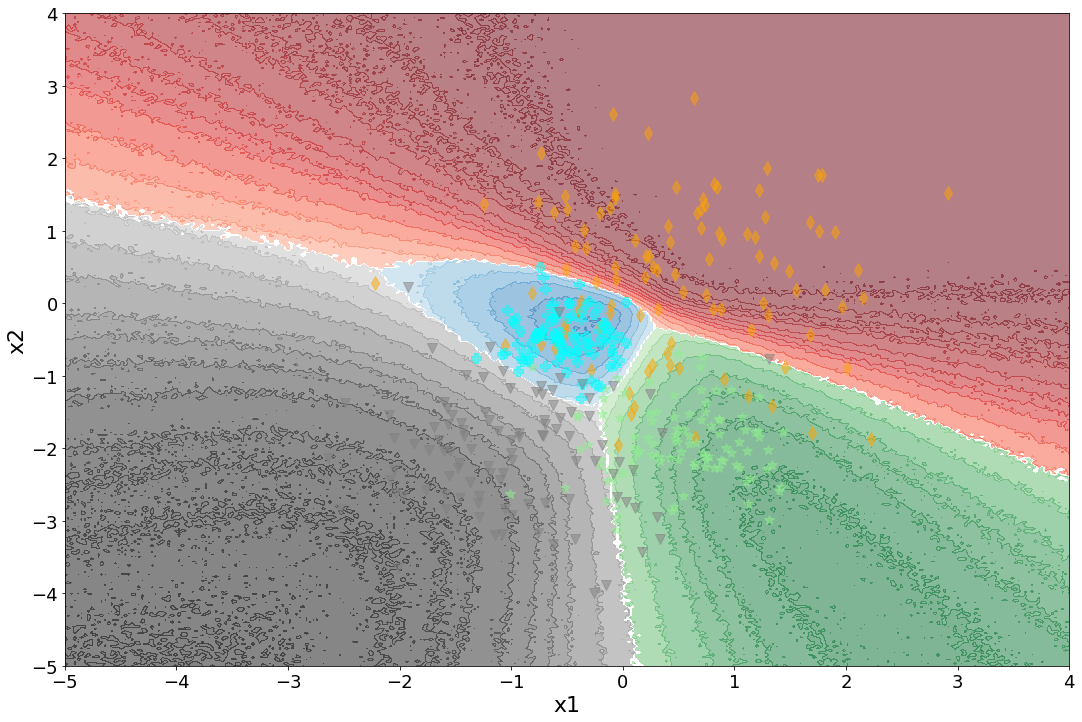

In [12]:
plot_toy_regions((X_tr, Y_tr), (X_te, Y_te), bnns[1]['model'])

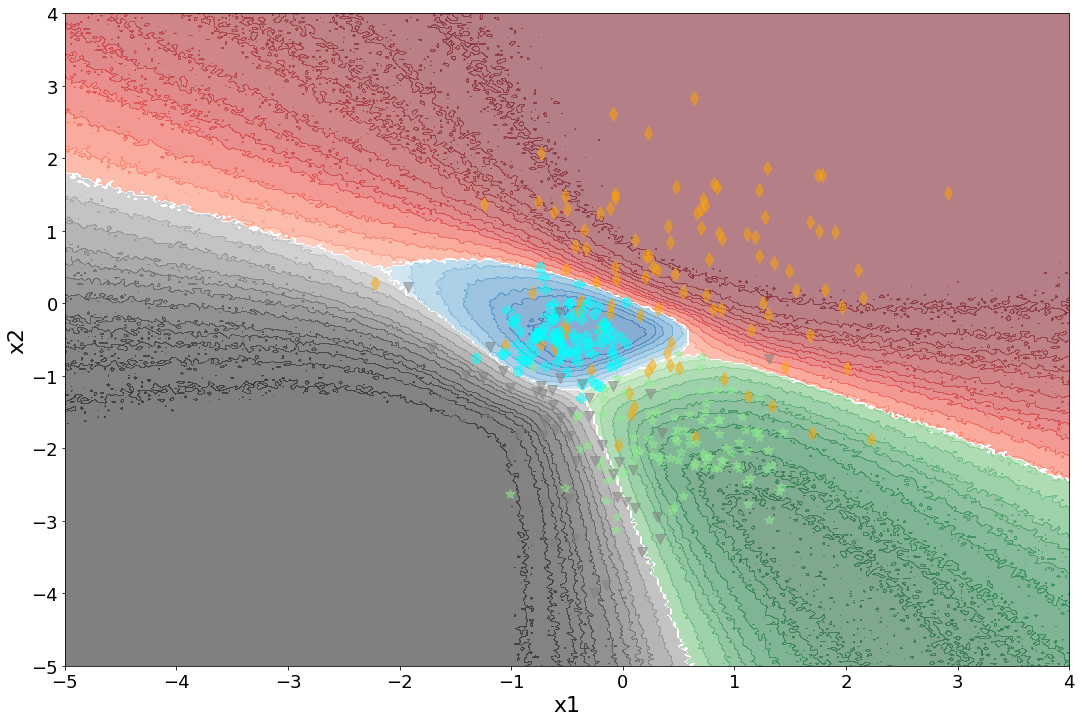

In [13]:
plot_toy_regions((X_tr, Y_tr), (X_te, Y_te), bnns[5]['model'])

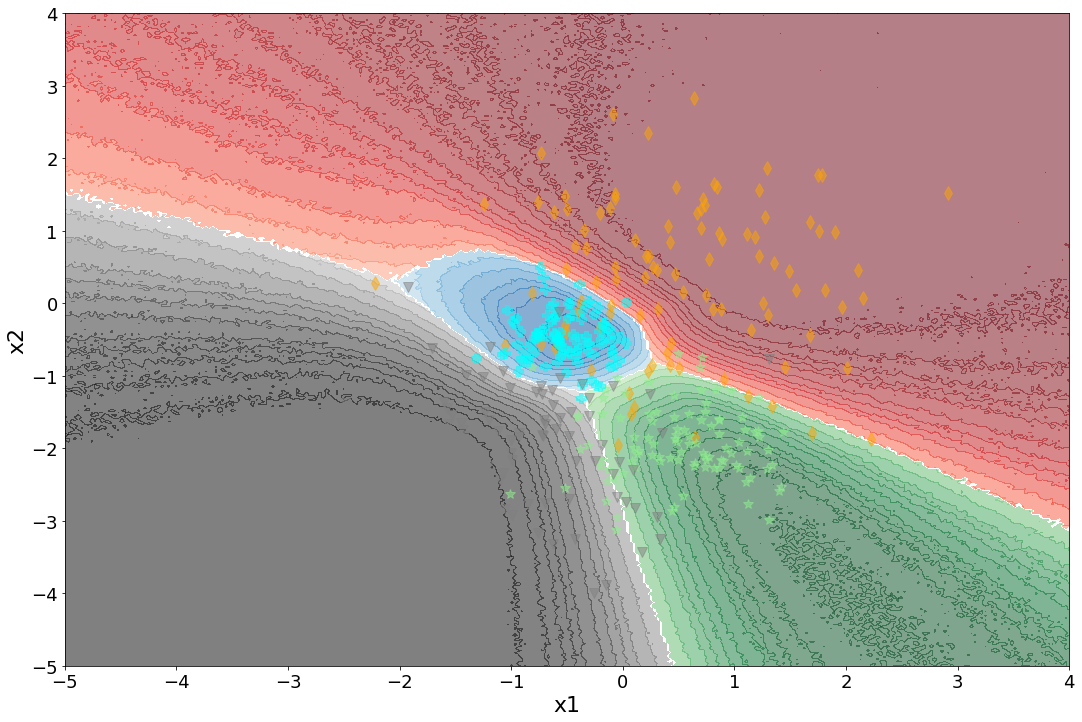

In [14]:
plot_toy_regions((X_tr, Y_tr), (X_te, Y_te), bnns[7]['model'])

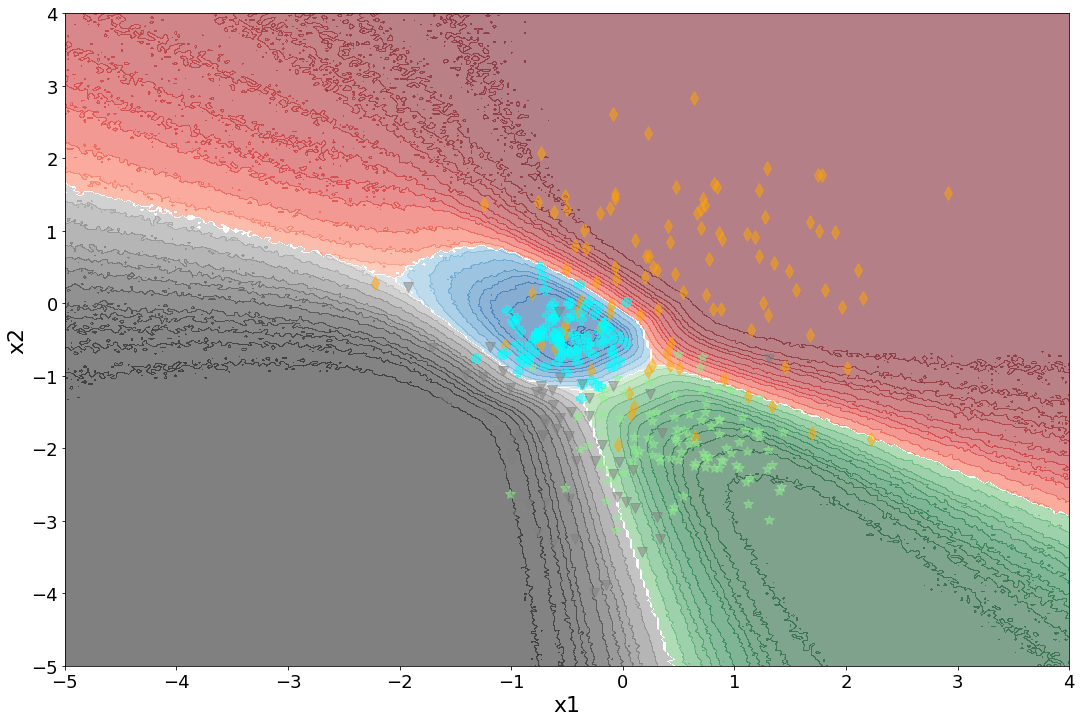

In [15]:
plot_toy_regions((X_tr, Y_tr), (X_te, Y_te), bnns[11]['model'])

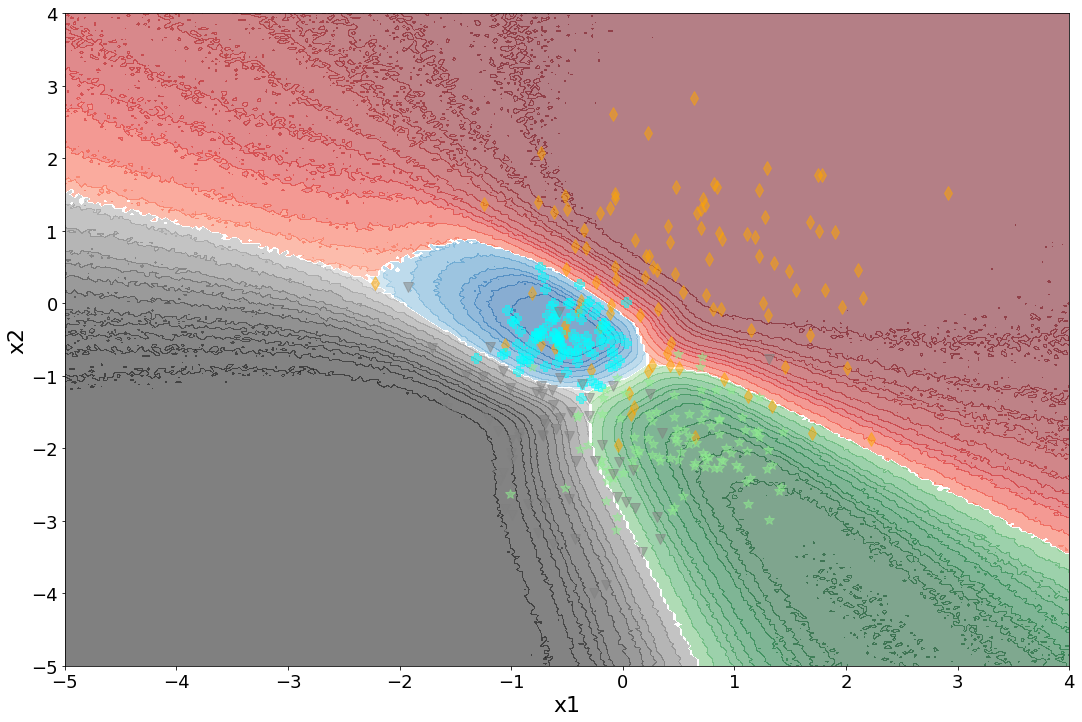

In [16]:
plot_toy_regions((X_tr, Y_tr), (X_te, Y_te), bnns[15]['model'])